# Imports

In [1]:
from __future__ import division  # always use float division
import numpy as np
from scipy.spatial.distance import cdist  # fast distance matrices
from scipy.cluster.hierarchy import dendrogram  # you can use this
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for when you create your own dendrogram
import scipy.io
from matplotlib.patches import Ellipse
import numpy.linalg as la
from numpy.random import default_rng
from scipy.special import logsumexp
from scipy import stats
import time

# Function Definitions - Implementation

In [2]:
def kmeans(X, k, max_iter=100, output=True):
    muselect = 0
    mu = np.random.rand(k, len(X[0]))
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)
    if muselect == 1:
        mu = np.random.rand(k, len(X[0]))
        mu += mins
        mu *= maxs
    elif muselect == 0:
        X_shuffle = np.array(X)
        np.random.shuffle(X_shuffle)
        mu = X_shuffle[0:k]
    r = np.empty(len(X))
    r_new = np.ones(len(X))
    iteration = 0
    error=0.
    while not np.array_equal(r,r_new) and iteration < max_iter:
        error=0.
        iteration+=1
        if output:
            print('Peforming iteration ' + str(iteration) + ':')
        r = r_new
        dis = (-2 * X @ mu.T + (np.sum(X ** 2, axis=1) + np.sum(mu ** 2, axis=1)[:, np.newaxis]).T)**0.5
        r_new = np.argmin(dis, axis=1)
        if output:
            print('Changed cluster memberships: ' +  str(np.count_nonzero(r_new-r)) + ' datapoints')
        for i in range(0, k):
            if(len(np.where(r_new==i)[0])>0):
                mu[i] = np.sum(X[np.where(r_new==i)], axis=0)/len(np.where(r_new==i)[0])
                error += np.sum(dis[np.where(r_new==i),i])
            else:
                dis = (-2 * X @ mu.T + (np.sum(X ** 2, axis=1) + np.sum(mu ** 2, axis=1)[:, np.newaxis]).T)**0.5
                mu[i] = X[np.where(dis == np.max(np.min(dis, axis=1)))[0][0]]
                print("Reinitialized: " + str(mu[i]))
        if output:
            print('Loss: ' + str(error))
    return mu, r_new, error

In [3]:
def agglo_dendro(kmloss, mergeidx, num=-1):
    """ Plots dendrogram for agglomerative clustering

    Input:
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """
    mergeloss = [[i] for i in kmloss[1:]]
    mergeloss -= kmloss[0]
    placeholder_counts = [[1] for i in kmloss[1:]]
    Z = np.append(mergeidx, mergeloss, axis=1)
    Z = np.append(Z, placeholder_counts, axis=1)
    fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))
    dn = dendrogram(Z, ax=axis)
    axis.set_ylabel('Increase in cost', fontsize=20)
    if num>=0:
         axis.set_xlabel('Cluster number, initial clusters: ' + str(num), fontsize=20)
    else:
        axis.set_xlabel('Cluster number', fontsize=20)
    pass

In [4]:
def agglo(X_a, r_a):
    #reconstruct original data
    k_org = max(r_a)+1
    org_err = 0.
    kmus = np.empty((k_org,len(X_a[0])))
    #calculate cluster centers
    for i in np.unique(r_a):
        if(len(np.where(r_a==i)[0])>0):
            kmus[i] = np.sum(X_a[np.where(r_a==i)], axis=0)/len(np.where(r_a==i)[0])
            #calculate distances
    org_dis = (-2 * X_a @ kmus.T + (np.sum(X_a ** 2, axis=1) + np.sum(kmus ** 2, axis=1)[:, np.newaxis]).T)**0.5
    #calculate errors
    for i in np.unique(r_a):
        if(len(np.where(r_a==i)[0])>0):
            org_err += np.sum(org_dis[np.where(r_a==i),i])
    #create return variable    
    R = np.array([r_a])
    kmloss = np.array([org_err])
    mergeidx = np.array([])
    costs = np.zeros((k_org,k_org))
    #for each combination of clusters (one way, not both ways) calculate cost of merging
    for first in range(0, k_org-1):
        if len(np.where(r_a==first)[0])>0:
            for second in range(first+1, k_org):
                if len(np.where(r_a==second)[0])>0:
                    if first != second:
                        numfirst = len(np.where(r_a==first)[0])
                        numsecond = len(np.where(r_a==second)[0])
                        #calculating weighted new clustercenter
                        newmu = (kmus[first]*numfirst+kmus[second]*numsecond)/(numfirst+numsecond)
                        newmus = np.append(kmus, [newmu], axis=0)
                        new_r = np.array(r_a)
                        new_r[np.where(r_a==first)] = k_org
                        new_r[np.where(r_a==second)] = k_org
                        dis = (-2 * X_a @ newmus.T + (np.sum(X_a ** 2, axis=1) + np.sum(newmus ** 2, axis=1)[:, np.newaxis]).T)**0.5
                        costs[first, second] = np.sum(dis[np.arange(dis.shape[0]), new_r])

    #Choose cheapest merge
    lowest_cost = np.min(costs[np.nonzero(costs)])
    indx = np.asarray(np.where(costs == lowest_cost)).flatten()
    merge_r = np.array(r_a)
    merge_r[np.where(merge_r==indx[0])] = k_org
    merge_r[np.where(merge_r==indx[1])] = k_org
    #preparing output
    mergeidx = np.array([indx])
    kmloss = np.append(kmloss, lowest_cost)
    
    #Recursion if needed:
    if len(np.unique(merge_r))>1:
        #R = np.append(R, [merge_r], axis=0)
        R_n, loss_n, mergeidx_n = agglo(X_a, merge_r)
        mergeidx = np.append(mergeidx, mergeidx_n, axis=0)
        kmloss = np.append(kmloss, loss_n[1:])
        R = np.append([merge_r], R_n, axis=0)
    return(R, kmloss, mergeidx)

In [5]:
def get_optimal_kmeans(X, k, reps=10, out=False):
    toterr = np.array([])
    locop_mu = np.array([])
    globop_mu = np.array([])
    lowmu, lowr, lowerr = kmeans(X, k, output=out)
    for i in range(0,reps-1):
        mu, r, err = kmeans(X, k, output=out)
        toterr = np.append(toterr, err)
        if err<=np.min(toterr):
            lowmu, lowr, lowerr = mu, r, err
    return lowmu, lowr, lowerr

In [6]:
def norm_pdf(X, mu, C):
    """ Computes probability density function for multivariate gaussian

    Input:
    X: (n x d) data matrix with each datapoint in one column
    mu: vector for center
    C: covariance matrix

    Output:
    pdf value for each data point
    """
    def log_pdf(X, mu, C):
        n, d = X.shape
        inv = la.solve(C, (X - mu).T).T
        maha = np.einsum('ij,ij->i', (X-mu), inv)
        # Directly calculates log(det(C)), bypassing the numerical issues
        # of calculating the determinant of C, which can be very close to zero
        _, logdet = la.slogdet(C)
        log2pi = np.log(2 * np.pi)
        return -0.5 * (d * log2pi + logdet + maha)

    logpdf = log_pdf(X, mu, C)
    return np.exp(logpdf), logpdf

In [7]:
def em_gmm(X, k, max_iter=100, init_kmeans=False, eps=1e-3,  plot_solution=False):
    """ Implements EM for Gaussian Mixture Models

    Input:
    X: (n x d) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations
    init_kmeans: whether kmeans should be used for initialisation
    eps: when log likelihood difference is smaller than eps, terminate loop

    Output:
    pi: k long vector of priors
    mu: (k x d) matrix with each cluster center in one column
    sigma: list of d x d covariance matrices
    """
    init_sample = False
    n, d = X.shape
    pi = np.ones(k)
    pi = pi / np.sum(pi)
    # sigma = np.repeat(np.cov(X.T)[np.newaxis], k, axis=0)
    x_std = np.std(X)
    sigma = np.repeat(0.6 * x_std*np.eye(d)[np.newaxis], k, axis=0)

    # np.random.seed(0)
    min_ = np.min(X)
    max_ = np.max(X)
    mu = np.random.uniform(min_, max_, (k, d))
    if init_kmeans:
        # 1. Using k-means
        mu, _, _ = kmeans(X, k)
        sigma += np.repeat(1e-4 * np.eye(d)[np.newaxis], k, axis=0)
    elif init_sample:
        rng = default_rng()
        mu = X[rng.choice(n, size=k, replace=False)]
        sigma += np.repeat(0.5 * np.eye(d)[np.newaxis], k, axis=0)
    else:
        sigma += np.repeat(0.5 * np.eye(d)[np.newaxis], k, axis=0)
    loglik = [0]
    r = np.zeros((n, k))
    log_r = np.zeros((n, k))
    if plot_solution:
        plot_gmm_solution(X, mu, sigma)
    for i in range(max_iter):

        ###### Step 1 - Expectation
        for c, m, s, p in zip(range(k), mu, sigma, pi):
            _, log_pdf = norm_pdf(X, m, s)
            log_r[:, c] = np.log(p) + log_pdf



        r_ = np.exp(log_r)
        loglik.append(np.log(np.sum(r_)))

        log_sum = logsumexp(log_r, axis=1)[:, None]
        log_r = log_r - log_sum
        r = np.exp(log_r)
        ###### Step 2 - Maximizaton
        n_k = np.sum(r, axis=0)
        pi = n_k / n

        ex_mu = mu.copy()
        mu = ((r.T @ X).T / n_k).T
        X_mu = X[:, np.newaxis] - mu[np.newaxis]

        # outer_prod = r[:, :, np.newaxis, np.newaxis] * np.matmul(X_mu[:, :, :, np.newaxis], X_mu[:, :, np.newaxis])
        # sigma = 1 / n_k[:, None, None] * np.sum((outer_prod).swapaxes(0, 1), axis=1)

        for j in range(k):
            r_diag = np.diag(r[:, j])
            sigma_k = (X_mu[:, j].T @ r_diag)
            sigma[j] = (sigma_k @ X_mu[:, j]) / n_k[j]

        sigma += np.repeat(1e-3 * np.eye(d)[np.newaxis], k, axis=0)
        if plot_solution:
            plot_gmm_solution(X, mu, sigma)
        if np.isclose(loglik[i], loglik[i - 1]):
            break

    return pi, mu, sigma, loglik[-1]

In [8]:
def plot_gmm_solution(X, mu, sigma):
    """ Plots covariance ellipses for GMM

    Input:
    X: (d x n) data matrix with each datapoint in one column
    mu: (d x k) matrix with each cluster center in one column
    sigma: list of d x d covariance matrices
    """
    k = len(mu)

    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(mu[:, 0], mu[:, 1], marker='x', c='red')

    for i in range(k):
        lambda_, v = np.linalg.eig(sigma[i])
        ellipse2 = Ellipse(xy=(mu[i, 0], mu[i, 1]),
                          width=lambda_[0] * 4,
                          height=lambda_[1] * 4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          facecolor='none',
                          edgecolor='red')
        ellipse3 = Ellipse(xy=(mu[i, 0], mu[i, 1]),
                          width=lambda_[0] * 8,
                          height=lambda_[1] * 8,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          facecolor='none',
                          edgecolor='red')
        ellipse4 = Ellipse(xy=(mu[i, 0], mu[i, 1]),
                          width=lambda_[0] * 16,
                          height=lambda_[1] * 16,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          facecolor='none',
                          edgecolor='red')
        ax.add_artist(ellipse2)
        ax.add_artist(ellipse3)
        ax.add_artist(ellipse4)
    plt.show()

    pass

## Testing Area

In [9]:
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
                  [1., 0., 1.,  0.,   0.5,  0.,  5.,   5.5,  5.]]).T
k = 3

In [10]:
X.shape

(9, 2)

In [13]:
mu, r, err = kmeans(X, k)

Peforming iteration 1:
Changed cluster memberships: 7 datapoints
Loss: 17.507346426788768
Peforming iteration 2:
Changed cluster memberships: 1 datapoints
Loss: 7.361240234640755
Peforming iteration 3:
Changed cluster memberships: 0 datapoints
Loss: 4.818351614360072


In [14]:
agglo(X, r)

(array([[2, 2, 2, 3, 3, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 3, 3, 3, 3]]),
 array([ 4.81835161, 17.17754944, 44.84545961]),
 array([[0, 1],
        [2, 3]]))

# Analysis/Application Part

In [15]:
gauss5 = np.load('data/5_gaussians.npy')
gauss5 = gauss5.T
gauss2 = np.load('data/2_gaussians.npy')
gauss2 = gauss2.T

## Ex.7

## Kmeans

In [78]:
g52mu, g52r, g52err = kmeans(gauss5, 2, output=False)
g53mu, g53r, g53err = kmeans(gauss5, 3, output=False)
g54mu, g54r, g54err = kmeans(gauss5, 4, output=False)
g55mu, g55r, g55err = kmeans(gauss5, 5, output=False)
g56mu, g56r, g56err = kmeans(gauss5, 6, output=False)
g57mu, g57r, g57err = kmeans(gauss5, 7, output=False)
#fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))


/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


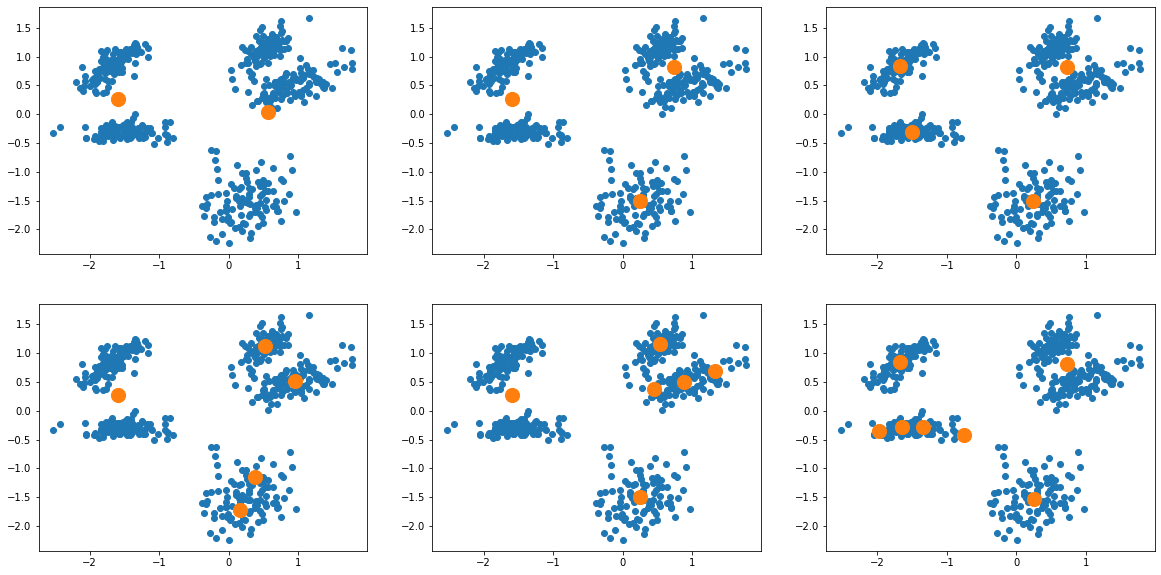

In [133]:
fig, axis = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for i in range(0, 3):
    axis[0][i].scatter(gauss5.T[0], gauss5.T[1])
    axis[1][i].scatter(gauss5.T[0], gauss5.T[1])
axis[0][0].scatter(g52mu.T[0], g52mu.T[1], s=200)
axis[0][1].scatter(g53mu.T[0], g53mu.T[1], s=200)
axis[0][2].scatter(g54mu.T[0], g54mu.T[1], s=200)
axis[1][0].scatter(g55mu.T[0], g55mu.T[1], s=200)
axis[1][1].scatter(g56mu.T[0], g56mu.T[1], s=200)
axis[1][2].scatter(g57mu.T[0], g57mu.T[1], s=200)

In [118]:
appl_localOptima(gauss5, reps=1000)

##############################
2 CLUSTERS: 


/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


   Global optimun: 454.72, achieved for 0.6% of the samples
   Mean error from 1000 samples: 15.86, which is 3.49% of the optimum
   INCLUDING global optima, 41.3% of the samples are within 2.0% of the global optimum
   1000 runs took a total of 1.2 seconds
##############################
3 CLUSTERS: 
   Global optimun: 265.4, achieved for 99.3% of the samples
   Mean error from 1000 samples: 288.07, which is 108.54% of the optimum
   INCLUDING global optima, 99.3% of the samples are within 2.0% of the global optimum
   1000 runs took a total of 1.4 seconds
##############################
4 CLUSTERS: 
   Global optimun: 190.66, achieved for 7.3% of the samples
   Mean error from 1000 samples: 24.42, which is 12.81% of the optimum
   INCLUDING global optima, 48.0% of the samples are within 2.0% of the global optimum
   1000 runs took a total of 1.6 seconds
##############################
5 CLUSTERS: 
   Global optimun: 153.12, achieved for 36.7% of the samples
   Mean error from 1000 sampl

/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


Reinitialized: [ 0.88184926 -0.72175702]


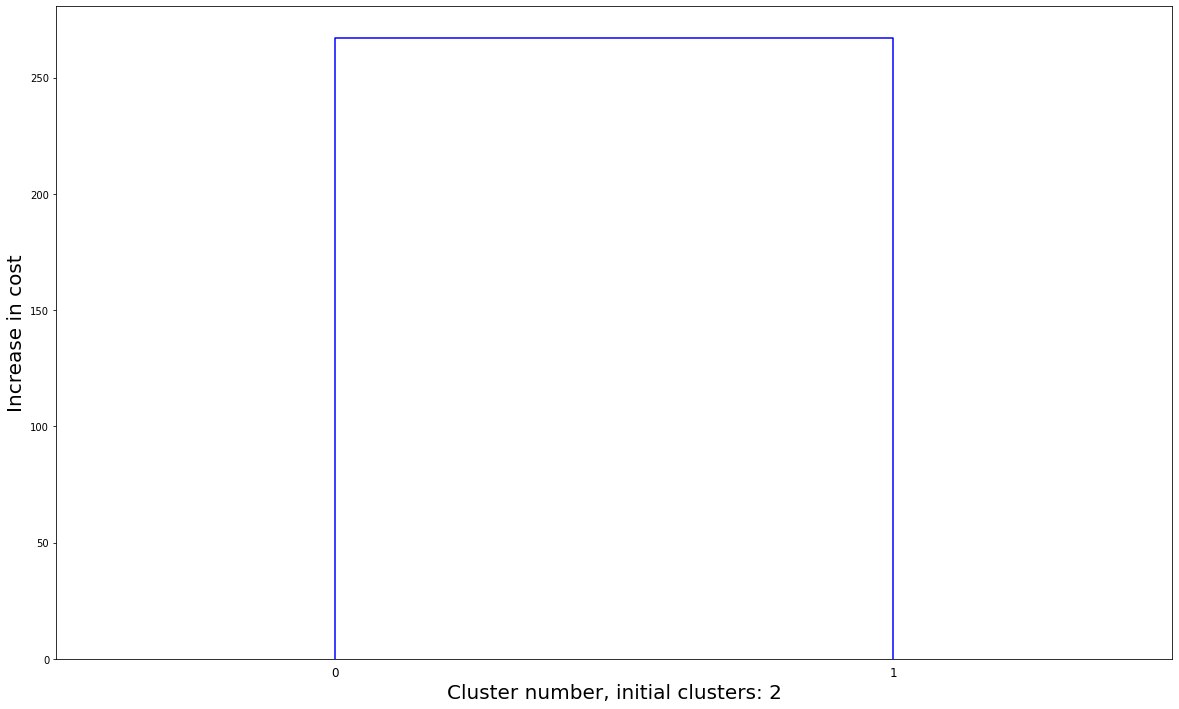

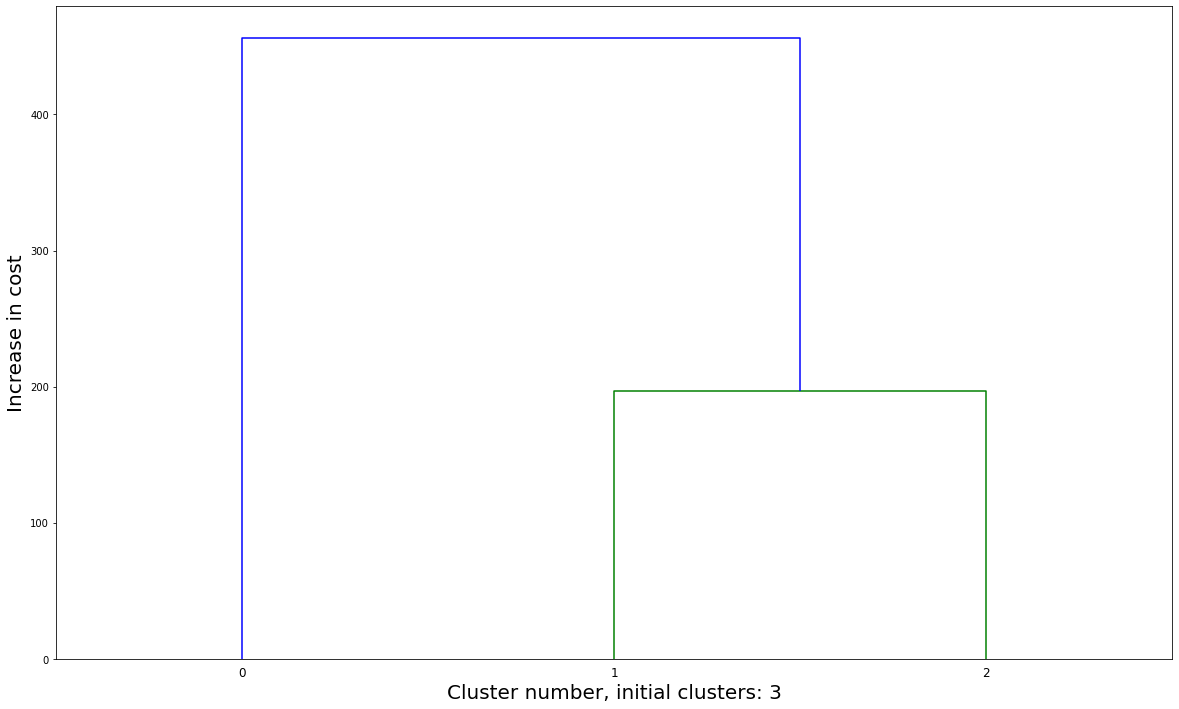

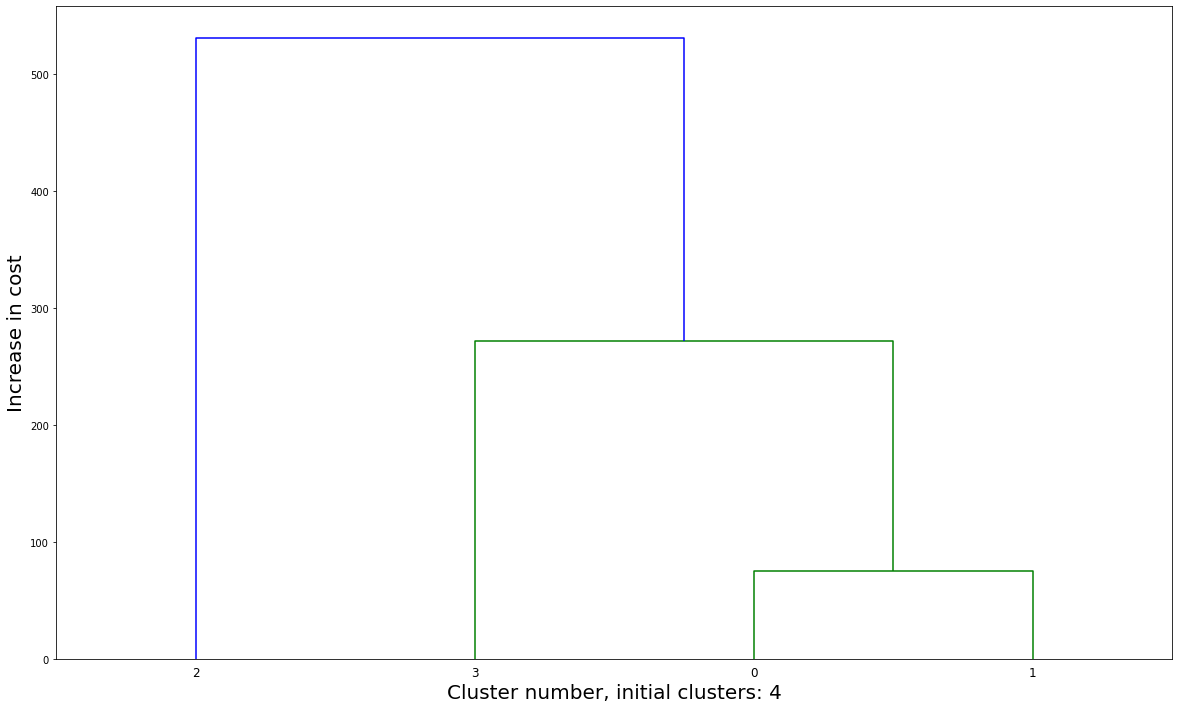

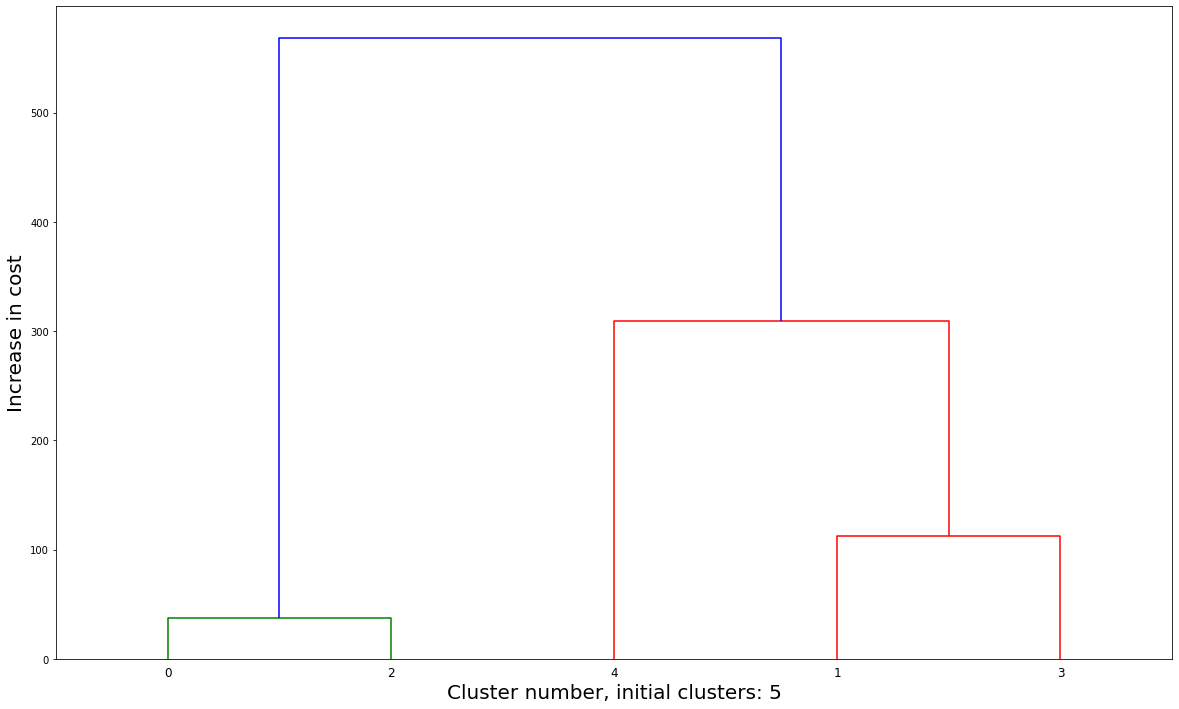

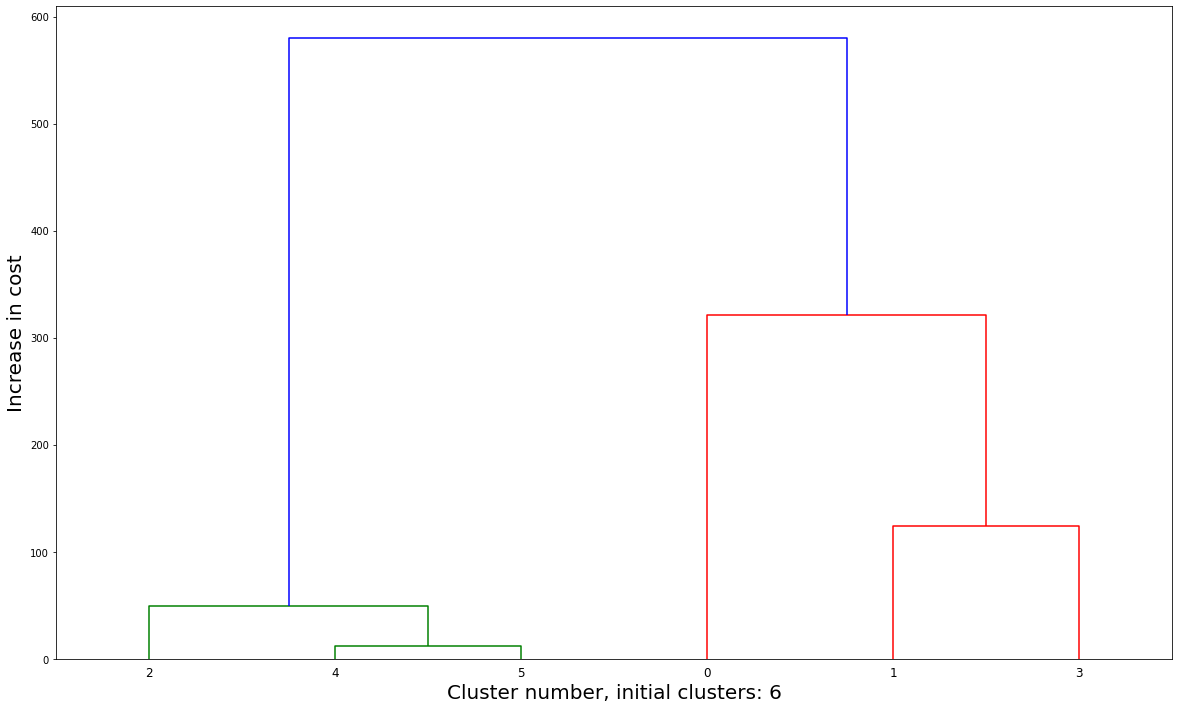

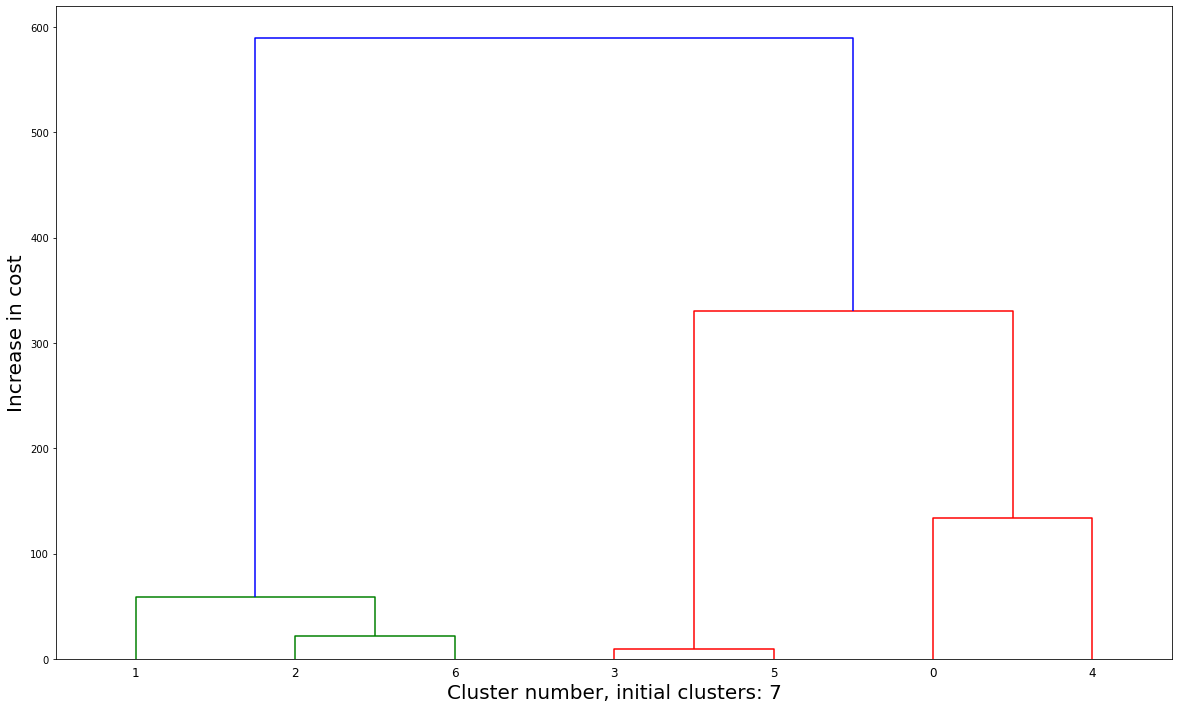

In [90]:
appl_dendo(gauss5)

## GMM

In [134]:
g52gpi, g52gmu, g52gsigma, g52gloglik = em_gmm(gauss5, 2, init_kmeans=False)
g53gpi, g53gmu, g53gsigma, g53gloglik = em_gmm(gauss5, 3, init_kmeans=False)
g54gpi, g54gmu, g54gsigma, g54gloglik = em_gmm(gauss5, 4, init_kmeans=False)
g55gpi, g55gmu, g55gsigma, g55gloglik = em_gmm(gauss5, 5, init_kmeans=False)
g56gpi, g56gmu, g56gsigma, g56gloglik = em_gmm(gauss5, 6, init_kmeans=False)
g57gpi, g57gmu, g57gsigma, g57gloglik = em_gmm(gauss5, 7, init_kmeans=False)

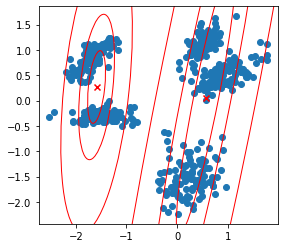

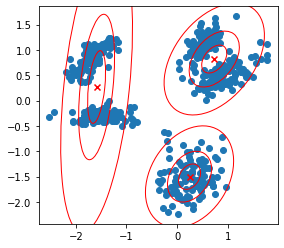

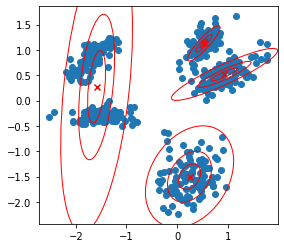

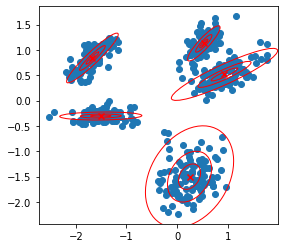

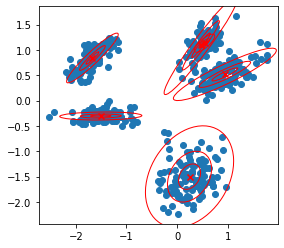

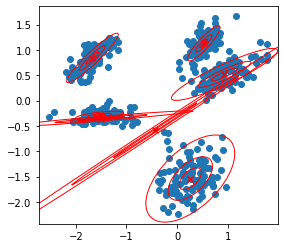

In [135]:
plot_gmm_solution(gauss5, g52gmu, g52gsigma)
plot_gmm_solution(gauss5, g53gmu, g53gsigma)
plot_gmm_solution(gauss5, g54gmu, g54gsigma)
plot_gmm_solution(gauss5, g55gmu, g55gsigma)
plot_gmm_solution(gauss5, g56gmu, g56gsigma)
plot_gmm_solution(gauss5, g57gmu, g57gsigma)

In [136]:
g54gpi

array([0.40000845, 0.19788443, 0.19999315, 0.20211398])

In [ ]:
axis.scatter(gauss5.T[0], gauss5.T[1])
#axis.scatter(g52mu.T[0], g52mu.T[1])
#axis.scatter(g53mu.T[0], g53mu.T[1])
#axis.scatter(g54mu.T[0], g54mu.T[1])
axis.scatter(g55mu.T[0], g55mu.T[1])
#axis.scatter(g56mu.T[0], g56mu.T[1])
#axis.scatter(g57mu.T[0], g57mu.T[1])

In [119]:
appl_localOptima(gauss2, reps=200, mode='g')

##############################
2 CLUSTERS: 
   Global optimun: 3.66, achieved for 0.5% of the samples
   Mean error from 200 samples: 0.19, which is 5.26% of the optimum
   INCLUDING global optima, 46.0% of the samples are within 2.0% of the global optimum
   200 runs took a total of 5.9 seconds
##############################
3 CLUSTERS: 
   Global optimun: 3.7, achieved for 0.5% of the samples
   Mean error from 200 samples: 0.04, which is 1.13% of the optimum
   INCLUDING global optima, 4.5% of the samples are within 2.0% of the global optimum
   200 runs took a total of 14.2 seconds
##############################
4 CLUSTERS: 
   Global optimun: 3.74, achieved for 0.5% of the samples
   Mean error from 200 samples: 0.04, which is 0.97% of the optimum
   INCLUDING global optima, 0.5% of the samples are within 2.0% of the global optimum
   200 runs took a total of 19.5 seconds
##############################
5 CLUSTERS: 
   Global optimun: 3.76, achieved for 0.5% of the samples
   Mean 

In [96]:
import math

In [99]:
math.log(g57gloglik)

1.6283067704581657

# Ex.8

## k-means

/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


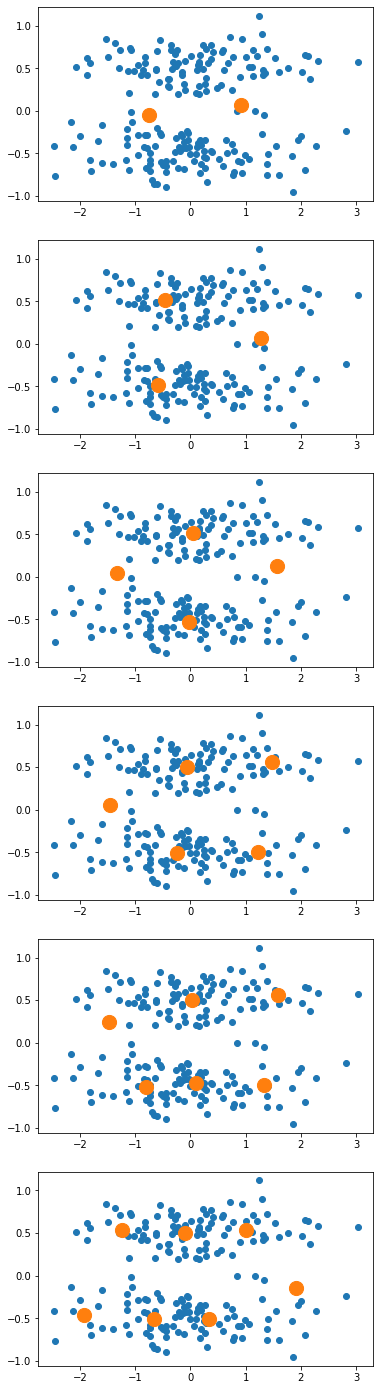

In [123]:
g22mu, g22r, g22err = get_optimal_kmeans(gauss2, 2, False)
g23mu, g23r, g23err = get_optimal_kmeans(gauss2, 3, False)
g24mu, g24r, g24err = get_optimal_kmeans(gauss2, 4, False)
g25mu, g25r, g25err = get_optimal_kmeans(gauss2, 5, False)
g26mu, g26r, g26err = get_optimal_kmeans(gauss2, 6, False)
g27mu, g27r, g27err = get_optimal_kmeans(gauss2, 7, False)

fig, axis = plt.subplots(nrows=6, ncols=1, figsize=(6, 25))
for i in range(0, 6):
    axis[i].scatter(gauss2.T[0], gauss2.T[1])
axis[0].scatter(g22mu.T[0], g22mu.T[1], s=200)
axis[1].scatter(g23mu.T[0], g23mu.T[1], s=200)
axis[2].scatter(g24mu.T[0], g24mu.T[1], s=200)
axis[3].scatter(g25mu.T[0], g25mu.T[1], s=200)
axis[4].scatter(g26mu.T[0], g26mu.T[1], s=200)
axis[5].scatter(g27mu.T[0], g27mu.T[1], s=200)

In [116]:
appl_localOptima(gauss2, reps=1000)

##############################
2 CLUSTERS: 


/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


   Global optimun: 156.35, achieved for 3.0% of the samples
   Mean error from 1000 samples: 0.22, which is 0.14% of the optimum
   INCLUDING global optima, 100.0% of the samples are within 2.0% of the global optimum
   1000 runs took a total of 1.2 seconds
##############################
3 CLUSTERS: 
   Global optimun: 129.23, achieved for 13.8% of the samples
   Mean error from 1000 samples: 3.34, which is 2.59% of the optimum
   INCLUDING global optima, 30.599999999999998% of the samples are within 2.0% of the global optimum
   1000 runs took a total of 1.5 seconds
##############################
4 CLUSTERS: 
   Global optimun: 107.19, achieved for 0.1% of the samples
   Mean error from 1000 samples: 2.7, which is 2.52% of the optimum
   INCLUDING global optima, 76.5% of the samples are within 2.0% of the global optimum
   1000 runs took a total of 2.3 seconds
##############################
5 CLUSTERS: 
   Global optimun: 94.28, achieved for 0.1% of the samples
   Mean error from 1000

In [107]:
appl_dendo(gauss2)

TypeError: appl_dendo() got an unexpected keyword argument 'reps'

## GMM

In [117]:
appl_localOptima(gauss2, mode='g', reps=400)

##############################
2 CLUSTERS: 
   Global optimun: 3.66, achieved for 0.25% of the samples
   Mean error from 400 samples: 0.17, which is 4.67% of the optimum
   INCLUDING global optima, 40.75% of the samples are within 2.0% of the global optimum
   400 runs took a total of 11.6 seconds
##############################
3 CLUSTERS: 
   Global optimun: 3.7, achieved for 0.25% of the samples
   Mean error from 400 samples: 0.06, which is 1.57% of the optimum
   INCLUDING global optima, 7.5% of the samples are within 2.0% of the global optimum
   400 runs took a total of 26.2 seconds
##############################
4 CLUSTERS: 
   Global optimun: 3.73, achieved for 0.25% of the samples
   Mean error from 400 samples: 0.03, which is 0.79% of the optimum
   INCLUDING global optima, 0.75% of the samples are within 2.0% of the global optimum
   400 runs took a total of 39.5 seconds
##############################
5 CLUSTERS: 
   Global optimun: 3.76, achieved for 0.25% of the samples
 

In [120]:
g22gpi, g22gmu, g22gsigma, g22gloglik = em_gmm(gauss2, 2, init_kmeans=False)
g23gpi, g23gmu, g23gsigma, g23gloglik = em_gmm(gauss2, 3, init_kmeans=False)
g24gpi, g24gmu, g24gsigma, g24gloglik = em_gmm(gauss2, 4, init_kmeans=False)
g25gpi, g25gmu, g25gsigma, g25gloglik = em_gmm(gauss2, 5, init_kmeans=False)
g26gpi, g26gmu, g26gsigma, g26gloglik = em_gmm(gauss2, 6, init_kmeans=False)
g27gpi, g27gmu, g27gsigma, g27gloglik = em_gmm(gauss2, 7, init_kmeans=False)

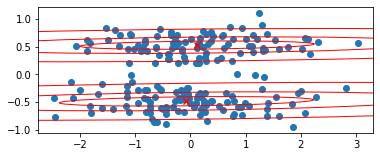

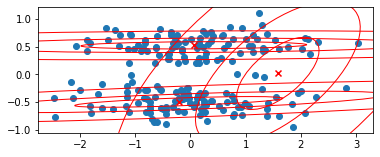

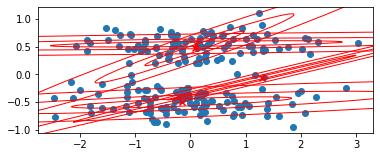

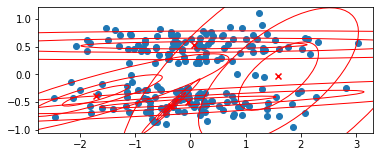

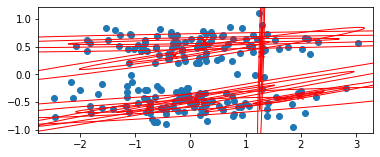

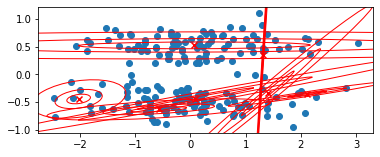

In [121]:
plot_gmm_solution(gauss2, g22gmu, g22gsigma)
plot_gmm_solution(gauss2, g23gmu, g23gsigma)
plot_gmm_solution(gauss2, g24gmu, g24gsigma)
plot_gmm_solution(gauss2, g25gmu, g25gsigma)
plot_gmm_solution(gauss2, g26gmu, g26gsigma)
plot_gmm_solution(gauss2, g27gmu, g27gsigma)

## Local Optima Check

In [114]:
def appl_localOptima(X, accept_perc=.02, reps=1000, k=7, mode='k'):
    timebegin = time.time()
    timesave = timebegin
    if mode=='k':
        #Globops: 
        #2-460, one locop, rare; 0.54% locop; 41.2 within 2%
        #3-260 (few times one locop); 99.3% globop; 99.7% within 2%
        #4-190, 2 locop, often; 8.3% globop; 49% within 2%
        #5-155, many locop often; 33.9% globop; 33.9% within 2%
        #6-141, many locop, also close to globop, often; 0.12% globop; 27.7% within 2%
        #7-138, many regular locop, also close to globop; 0.08% globop; 21.6% within 2%
        for j in range(2, 8):
            timesave = time.time()
            toterr = np.array([])
            locop_mu = np.array([])
            globop_mu = np.array([])
            print("##############################")
            print(str(j) + " CLUSTERS: ")
            for i in range(0,reps):
                mu, r, err = kmeans(X, j, output=False)
                toterr = np.append(toterr, err)
                #print(np.max(toterr))
                if err>=np.max(toterr):
                    locop_mu = mu
                    #print("new max")
                    #print(i)
                    #print(err)
                if err<=np.min(toterr):
                    globop_mu = mu
                    #print("new min")
                    #print(i)
                    #print(err)
            global_optimum = np.min(np.unique(toterr, return_counts=True)[0])
            indx = np.where(np.unique(toterr, return_counts=True)[0]==global_optimum)
            indx = np.asarray(indx)[0,0]
            times = np.unique(toterr, return_counts=True)[1][indx]
            print("   Global optimun: " +str(round(global_optimum,2)) + ", achieved for " + str(round((times/reps)*100,2)) + "% of the samples")
            meanerr = np.sum((toterr - global_optimum)) / (reps-times)
            print("   Mean error from " + str(reps) + " samples: " + str(round(meanerr,2)) + ", which is " + str(round((meanerr/global_optimum)*100,2)) + "% of the optimum")
            perc = global_optimum * accept_perc
            inperc = toterr-(perc+global_optimum)
            inperccount = len(np.where(inperc<0)[0])
            print("   INCLUDING global optima, " + str((inperccount/reps)*100) + "% of the samples are within " + str(accept_perc*100) + "% of the global optimum")
            print("   " + str(reps) + " runs took a total of " + str(round(time.time()-timesave,1)) + " seconds")
            #fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))
            #axis[0].plot(toterr)
            #axis[1].scatter(gauss5.T[0], gauss5.T[1])
            #axis[1].scatter(locop_mu.T[0], locop_mu.T[1])
            #axis[1].scatter(globop_mu.T[0], globop_mu.T[1], c='r')
    elif mode=='g':
        #Globops: 
        #2-460, one locop, rare; 0.54% locop; 41.2 within 2%
        #3-260 (few times one locop); 99.3% globop; 99.7% within 2%
        #4-190, 2 locop, often; 8.3% globop; 49% within 2%
        #5-155, many locop often; 33.9% globop; 33.9% within 2%
        #6-141, many locop, also close to globop, often; 0.12% globop; 27.7% within 2%
        #7-138, many regular locop, also close to globop; 0.08% globop; 21.6% within 2%
        for j in range(2, 8):
            timesave = time.time()
            totlog = np.array([])
            
            locop_mu = np.array([])
            locop_pi = np.array([])
            locop_sigma = np.array([])
            
            globop_mu = np.array([])
            globop_pi = np.array([])
            globop_sigma = np.array([])
            
            print("##############################")
            print(str(j) + " CLUSTERS: ")
            for i in range(0,reps):
                pi, mu, sigma, loglik = em_gmm(X, j, init_kmeans=False)
                totlog = np.append(totlog, loglik)
                #print(np.max(totlog))
                if loglik<=np.min(totlog):
                    locop_mu = mu
                    locop_pi = pi
                    locop_sigma = sigma
                    #print("new max")
                    #print(i)
                    #print(err)
                if loglik>=np.max(totlog):
                    globop_mu = mu
                    globop_sigma = sigma
                    globop_pi = pi
                    #print("new min")
                    #print(i)
                    #print(err)
            global_optimum = np.max(np.unique(totlog, return_counts=True)[0])
            indx = np.where(np.unique(totlog, return_counts=True)[0]==global_optimum)
            indx = np.asarray(indx)[0,0]
            times = np.unique(totlog, return_counts=True)[1][indx]
            print("   Global optimun: " +str(round(global_optimum,2)) + ", achieved for " + str(round((times/reps)*100,2)) + "% of the samples")
            meanerr = -1*np.sum((totlog - global_optimum)) / (reps-times)
            print("   Mean error from " + str(reps) + " samples: " + str(round(meanerr,2)) + ", which is " + str(round((meanerr/global_optimum)*100,2)) + "% of the optimum")
            perc = global_optimum * accept_perc
            inperc = totlog-(global_optimum-perc)
            inperccount = len(np.where(inperc<0)[0])
            print("   INCLUDING global optima, " + str((inperccount/reps)*100) + "% of the samples are within " + str(accept_perc*100) + "% of the global optimum")
            print("   " + str(reps) + " runs took a total of " + str(round(time.time()-timesave,1)) + " seconds")

# Dendogram

In [89]:
def appl_dendo(X):
    for j in range(2, 8):
        mu, r, err = get_optimal_kmeans(X, j, 100)
        R, kmloss, mergeidx = agglo(X, r)
        agglo_dendro(kmloss, mergeidx, j)

# USPS

In [44]:
from PIL import Image

In [45]:
usps = scipy.io.loadmat('data/usps.mat')
data = usps['data_patterns'].T
n, d = data.shape

In [46]:
data.shape

(2007, 256)

In [124]:
kmus, kr, kerr = get_optimal_kmeans(data, 10, reps=10)

In [125]:
test = np.array(kmus)
cimg = np.empty((10,16,16))
for i in range(0,10):
    cimg[i] = test[i].reshape(16,16)

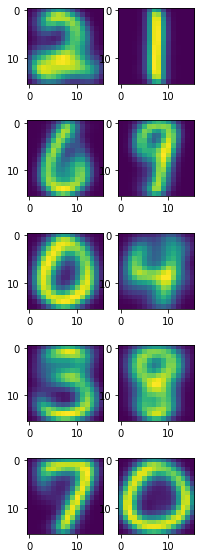

In [126]:
fig, axis = plt.subplots(nrows=5, ncols=2, figsize=(3, 10))
for i in range(0,10):
    y= (i%2)
    x = (int(i/2))
    axis[x][y].imshow(cimg[i]) #

In [225]:
#1 4 7 6 2 3 0 8 9 0
#0 1 2 3 4 5 6 7 8 9
data.shape

(2007, 256)

In [232]:
kmus, kr, kerr = get_optimal_kmeans(data, 10, reps=10)

In [466]:
R, kmloss, mergeidx = agglo(data, kr)
#print(R)

In [250]:
mergeidx

array([[ 3,  4],
       [ 1,  7],
       [ 2,  8],
       [ 0, 12],
       [11, 13],
       [ 6, 10],
       [ 5,  9],
       [15, 16],
       [14, 17]])

In [251]:
len(np.where(R[0]==4)[0])

0

In [143]:
iniC = np.array([[0]])
for i in range (1, 10):
    iniC = np.append(iniC, [i])  
print(iniC)

[0 1 2 3 4 5 6 7 8 9]


In [203]:
def returnSingu(merge, idx, k):
    #print(merge)
    singu = np.array([])
    if(merge[0]>9):
        #print(merge[0])
        a = returnSingu(idx[merge[0]-k], idx, k)
    else:
        a = merge[0]
        #print("a: "+str(a))
    if(merge[1]>9):
        #print(merge[1])
        b = returnSingu(idx[merge[1]-k], idx, k)
    else:
        b = merge[1]
        #print("b: "+str(b))
    return (np.append(a, b))

In [468]:
def combineCentroids(merge, centroids):
    combi = np.empty(len(centroids[0]))
    for m in merge:
        combi+=centroids[m]
    combi/=len(merge)
    return combi

In [204]:
singular = np.array([])


In [205]:
returnSingu(mergeidx[(13-10)], idx=mergeidx, k=10)

array([7, 2, 1, 4])

In [ ]:
for j in mergeidx

    fig, axis = plt.subplots(nrows=5, ncols=2)#, figsize=(20, 12))
    for i in range(0,currk):
        y= (i%2)
        x = (int(i/2))
        axis[x][y].imshow(cimg[i])

In [266]:
mergeclusters = np.empty((0,256))
for m in mergeidx:
    a = returnSingu(m, mergeidx, 10)
    #print(mergeclusters.shape)
    #print(combineCentroids(a, kmus).shape)
    mergeclusters = np.append(mergeclusters, combineCentroids(a, kmus))
mergeclusters = mergeclusters.reshape(9, 256)

In [526]:
len(kmus)

10

In [549]:
def agglo_img(X, k, dendro = False):
    kmus, kr, kerr = get_optimal_kmeans(data, k, reps=20)
    R, kmloss, mergeidx = agglo(data, kr)
    
    if(dendro):
        agglo_dendro(kmloss, mergeidx)
    
    test = np.array(kmus)
    cimg = np.empty((10,16,16))
    for i in range(0,k):
        cimg[i] = test[i].reshape(16,16)
    
    fig, axis = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(0,k):
        x= (i%2)
        y = (int(i/2))
        axis[x][y].imshow(cimg[i])
        axis[x][y].set_xlabel(('#' + str(i)), fontsize=11)
        axis[x][y].set_xticks([]) 
        axis[x][y].set_yticks([])
        
    mergeclusters = np.empty((0,256))
    for m in mergeidx:
        a = returnSingu(m, mergeidx, k)
        #print(mergeclusters.shape)
        #print(combineCentroids(a, kmus).shape)
        mergeclusters = np.append(mergeclusters, combineCentroids(a, kmus))
    #mergeclusters = np.append(mergeclusters, combineCentroids(np.arange(len(kmus)), kmus))
    mergeclusters = mergeclusters.reshape(k-1, 256)
    
    
    mimg = np.empty((k,16,16))
    for i in range(0,k-1):
        mimg[i] = mergeclusters[i].reshape(16,16)
    
    print(mergeidx)
    for j in range(0, len(mergeidx)):
        #print("###")
        #print(mergeidx[j])
        #print(np.unique(R[j]))
        col = int((j+1)/2)
        fig, axis = plt.subplots(nrows=2, ncols=5-col, figsize=(12, 4))
        axcount = 0
        count = 0
        for i in range(0,k+j+1):
            if len(np.where(R[j]==i)[0])>0 or (j==len(mergeidx)-1 and i==k+j):
                count+=1
                x= (axcount%2)
                y = (int(axcount/2))
                if(i<10):
                    if 5-col>1:
                        axis[x][y].imshow(cimg[i])
                    else:
                        axis[y].imshow(cimg[i])

                else:
                    if 5-col>1:
                        axis[x][y].imshow(mimg[i-10])
                    else:
                        axis[y].imshow(mimg[i-10])
                if 5-col>1:
                    axis[x][y].set_xlabel(('#' + str(i)), fontsize=11)
                    axcount+=1
                    axis[x][y].set_xticks([]) 
                    axis[x][y].set_yticks([]) 
                else:
                    axis[y].set_xlabel(('#' + str(i)), fontsize=11)
                    axcount+=1
                    axis[y].set_xticks([]) 
                    axis[y].set_yticks([])
    
    #fig, axis = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    #for i in range(0,k):
    #    x= (i%2)
    #    y = (int(i/2))
    #    axis[x][y].imshow(mimg[len(mimg)-1])
    #    axis[x][y].set_xlabel(('# all'), fontsize=11)
    #    axis[x][y].set_xticks([]) 
    #    axis[x][y].set_yticks([])

[[ 3  6]
 [ 0  5]
 [ 9 11]
 [ 1 10]
 [ 2  7]
 [ 4 13]
 [12 15]
 [14 16]
 [ 8 17]]


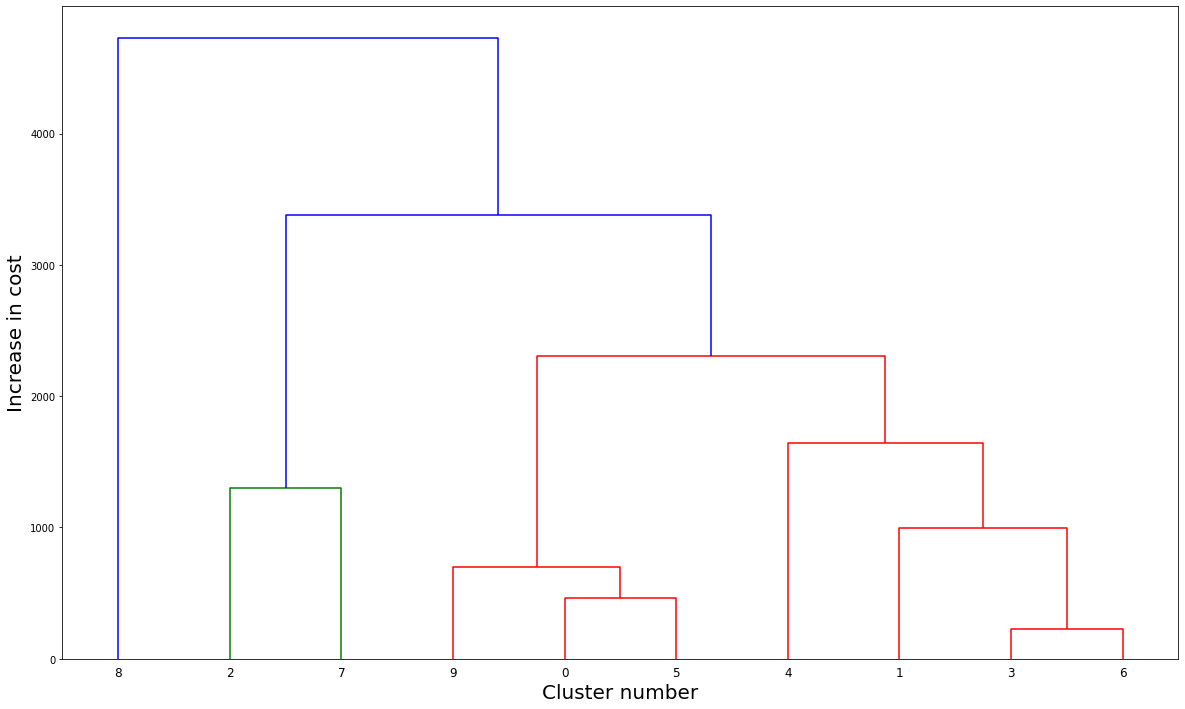

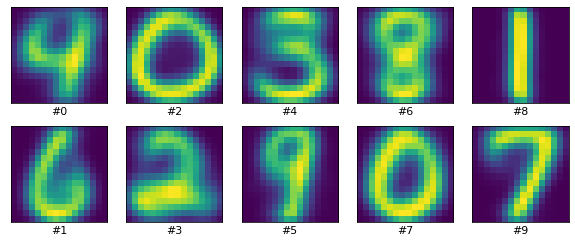

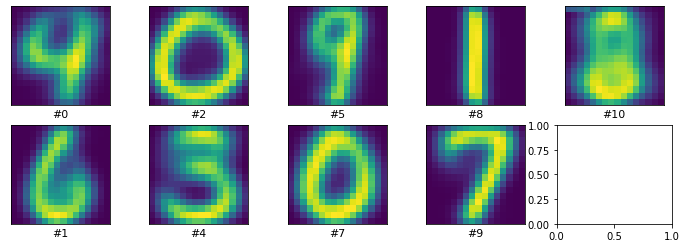

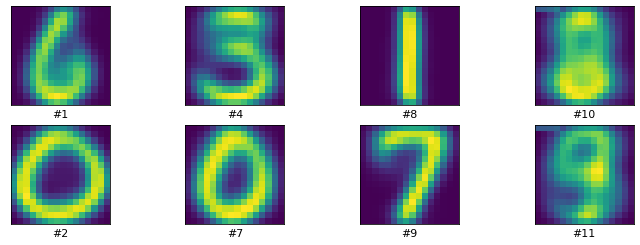

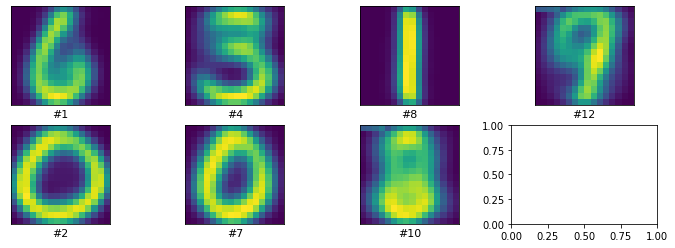

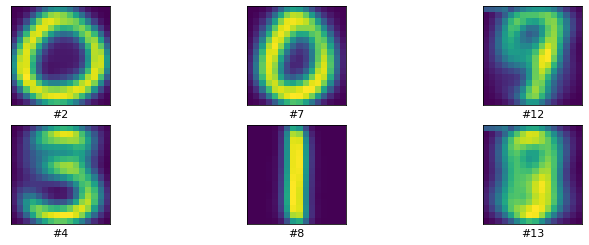

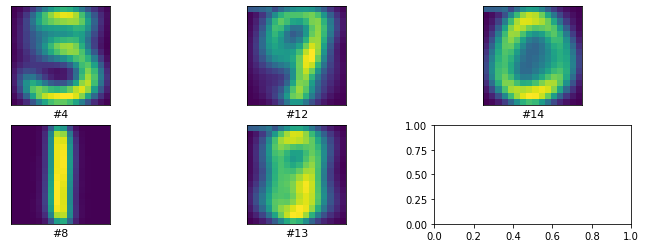

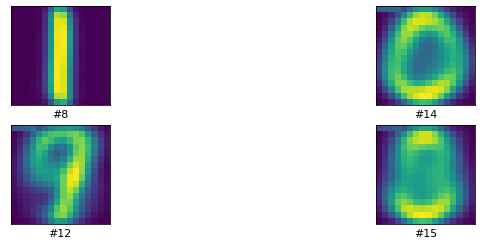

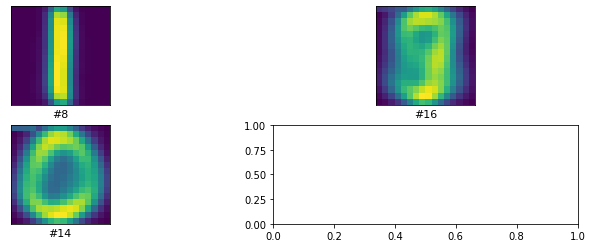

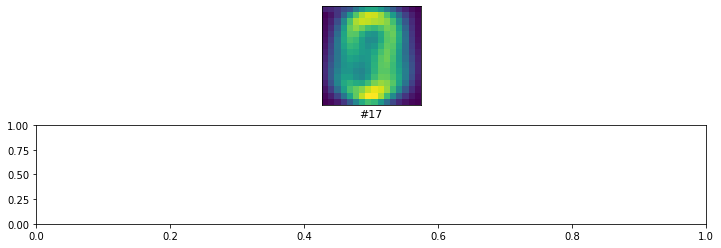

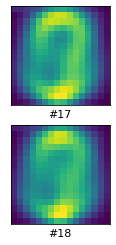

In [553]:
agglo_img(data, 10, True)

In [16]:
X = np.load("data/lab_data.npz")

In [28]:
X["X"].shape

(1000, 3)

# Notes

In [ ]:
def aggloOld(X_a, r_a):
    #construct original data
    k_org = max(r)+1
    org_err = 0.
    kmus = np.zeros((k_org,len(X[0])))
    org_dis = (-2 * X @ kmus.T + (np.sum(X ** 2, axis=1) + np.sum(kmus ** 2, axis=1)[:, np.newaxis]).T)**0.5
    for i in range(0, k_org):
        if(len(np.where(r==i)[0])>0):
            kmus[i] = np.sum(X[np.where(r==i)], axis=0)/len(np.where(r==i)[0])
            org_err += np.sum(org_dis[np.where(r==i),i])
    #create return variable
    R = np.array([r])
    kmloss = np.array([org_err])
    mergeidx = np.array([])
    costs = np.zeros((k_org,k_org))
    #for each combination of clusters (one way, not both ways) calculate cost of merging
    for first in range(0, k_org-1):
        if len(np.where(r==first)[0])>0:
            for second in range(first+1, k_org):
                if len(np.where(r==second)[0])>0:
                    if first != second:
                        numfirst = len(np.where(r==first)[0])
                        numsecond = len(np.where(r==second)[0])
                        #calculating weighted new clustercenter
                        newmu = (kmus[first]*numfirst+kmus[second]*numsecond)/(numfirst+numsecond)
                        newmus = np.append(kmus, [newmu], axis=0)
                        new_r = np.array(r)
                        new_r[np.where(r==first)] = k_org
                        new_r[np.where(r==second)] = k_org
                        dis = (-2 * X @ newmus.T + (np.sum(X ** 2, axis=1) + np.sum(newmus ** 2, axis=1)[:, np.newaxis]).T)**0.5
                        costs[first, second] = np.sum(dis[np.arange(dis.shape[0]),new_r])
    #Choose cheapest merge
    lowest_cost = np.min(costs[np.nonzero(costs)])
    indx = np.asarray(np.where(costs == lowest_cost)).flatten()
    merge_r = np.array(r)
    merge_r[np.where(merge_r==indx[0])] = k_org
    merge_r[np.where(merge_r==indx[1])] = k_org
    #preparing output
    if(len(R)==1): #needed for first entry
        mergeidx = np.array([indx])
    else:
        mergeidx = np.append(mergeidx, [indx], axis=0)
    kmloss = np.append(kmloss, lowest_cost)
    R = np.append(R, [merge_r], axis=0)
    #Recursion if needed:
    if(len(np.unique(merge_r))>2):
        print(merge_r)
        R_n, loss_n, mergeidx_n = agglo(X_a, merge_r)
        mergeidx = np.append(mergeidx, [mergeidx_n], axis=0)
        kmloss = np.append(kmloss, loss_n)
        R = np.append(R, [merge_r], axis=0)
    return(R, kmloss, mergeidx)